In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
torch.manual_seed(1)
batch_size=512

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=[0, 0, 0]),
    A.RandomCrop(height=32, width=32),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.2),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
    A.CoarseDropout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=0, p=0.5),
    ToTensorV2()
])

# Test Phase transformations
test_transforms = A.Compose([
    A.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
    ToTensorV2(),
])

/tmp/ipython-input-2059028457.py:13: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=[0, 0, 0]),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2059028457.py:20: UserWarning: Argument(s) 'num_holes, max_h_size, max_w_size, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=0, p=0.5),


In [3]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
class AlbumentationsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)  # Convert PIL to NumPy

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [4]:
from torchvision import datasets

base_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
train_dataset = AlbumentationsDataset(base_dataset, transform=train_transforms)

base_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
test_dataset = AlbumentationsDataset(base_dataset, transform=test_transforms)

if use_cuda:
  dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
else:
  dataloader_args = dict(shuffle=True, batch_size=batch_size)


train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)


100%|██████████| 170M/170M [00:32<00:00, 5.22MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())


In [7]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18()
model.to(device)
summary(model, input_size=(3, 32, 32))

True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch, criterion, scheduler=None):
  model.train()
  pbar = tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target) # Use the passed criterion
    loss.backward()
    optimizer.step()
    if scheduler is not None:
        scheduler.step()
    train_losses.append(loss.item())
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    processed = len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item() # Removed reduction='sum'
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_acc.append(100. * correct / len(test_loader.dataset))


  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader),
                                          epochs=20, pct_start=0.4, anneal_strategy='cos',div_factor=15)

for epoch in range(20):
  print(epoch+1)
  train(model, device, train_loader, optimizer, epoch, criterion, scheduler)
  test(model, device, test_loader, criterion)

1


Loss=1.0167981386184692 Batch_id=97 Accuracy=61.61: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 0.0017, Accuracy: 6996/10000 (69.96%)

2


Loss=0.9740458726882935 Batch_id=97 Accuracy=66.37: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0018, Accuracy: 6903/10000 (69.03%)

3


Loss=0.845190167427063 Batch_id=97 Accuracy=70.83: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.0018, Accuracy: 6776/10000 (67.76%)

4


Loss=0.8285022974014282 Batch_id=97 Accuracy=71.13: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0015, Accuracy: 7433/10000 (74.33%)

5


Loss=0.7696380615234375 Batch_id=97 Accuracy=72.62: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0015, Accuracy: 7423/10000 (74.23%)

6


Loss=0.7466328144073486 Batch_id=97 Accuracy=73.51: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0013, Accuracy: 7815/10000 (78.15%)

7


Loss=0.6361385583877563 Batch_id=97 Accuracy=78.27: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0014, Accuracy: 7689/10000 (76.89%)

8


Loss=0.5147982835769653 Batch_id=97 Accuracy=82.44: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set: Average loss: 0.0012, Accuracy: 7931/10000 (79.31%)

9


Loss=0.5664210319519043 Batch_id=97 Accuracy=80.06: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0011, Accuracy: 8108/10000 (81.08%)

10


Loss=0.5660967230796814 Batch_id=97 Accuracy=78.27: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0011, Accuracy: 8127/10000 (81.27%)

11


Loss=0.4637475609779358 Batch_id=97 Accuracy=85.12: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set: Average loss: 0.0010, Accuracy: 8238/10000 (82.38%)

12


Loss=0.43910980224609375 Batch_id=97 Accuracy=83.33: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0011, Accuracy: 8168/10000 (81.68%)

13


Loss=0.463050901889801 Batch_id=97 Accuracy=84.23: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0009, Accuracy: 8560/10000 (85.60%)

14


Loss=0.3744680881500244 Batch_id=97 Accuracy=85.12: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0008, Accuracy: 8651/10000 (86.51%)

15


Loss=0.3397194743156433 Batch_id=97 Accuracy=88.69: 100%|██████████| 98/98 [00:43<00:00,  2.28it/s]



Test set: Average loss: 0.0008, Accuracy: 8690/10000 (86.90%)

16


Loss=0.29612722992897034 Batch_id=97 Accuracy=89.88: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0007, Accuracy: 8798/10000 (87.98%)

17


Loss=0.305602490901947 Batch_id=97 Accuracy=88.69: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.0007, Accuracy: 8865/10000 (88.65%)

18


Loss=0.24516044557094574 Batch_id=97 Accuracy=90.77: 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]



Test set: Average loss: 0.0006, Accuracy: 9034/10000 (90.34%)

19


Loss=0.17671576142311096 Batch_id=97 Accuracy=94.05: 100%|██████████| 98/98 [00:42<00:00,  2.31it/s]



Test set: Average loss: 0.0005, Accuracy: 9106/10000 (91.06%)

20


Loss=0.18872308731079102 Batch_id=97 Accuracy=93.15: 100%|██████████| 98/98 [00:42<00:00,  2.29it/s]



Test set: Average loss: 0.0005, Accuracy: 9119/10000 (91.19%)



Text(0.5, 1.0, 'Test Accuracy')

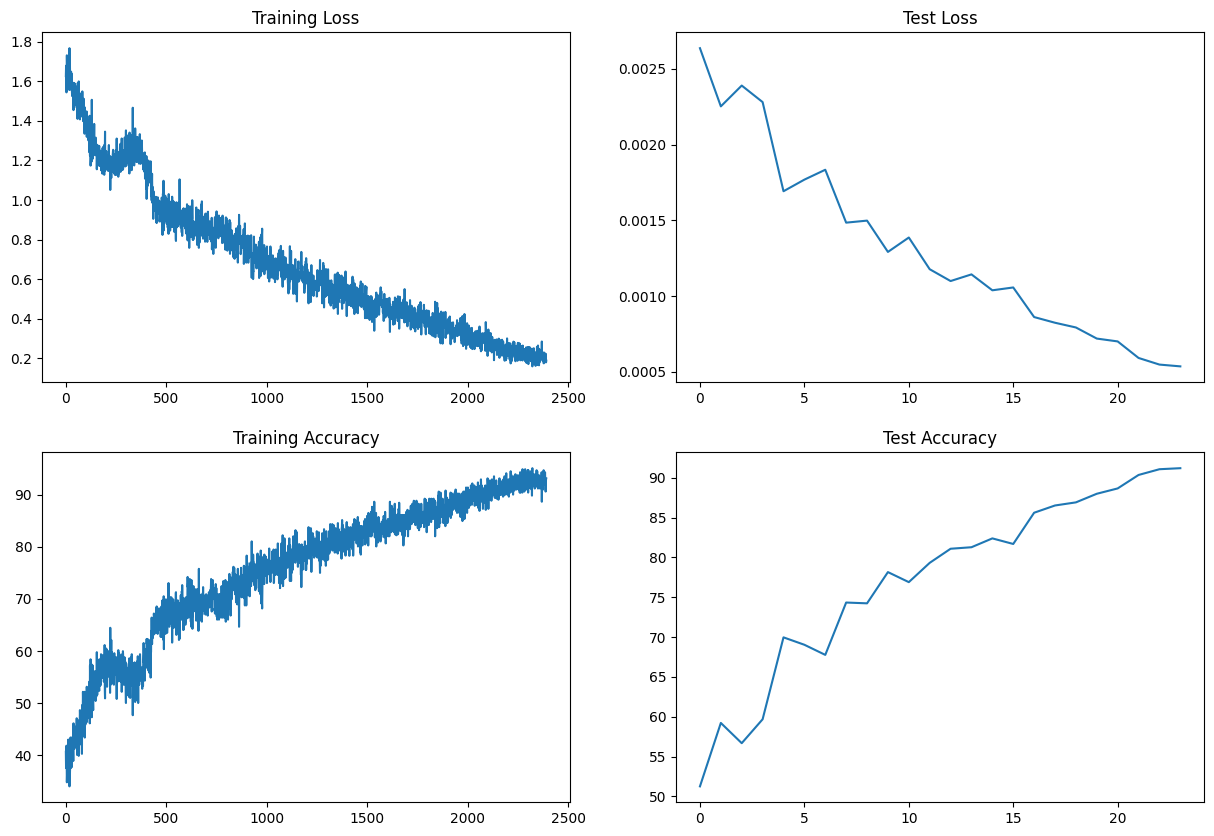

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [18]:
misclassified = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((images[i], labels[i], preds[i]))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


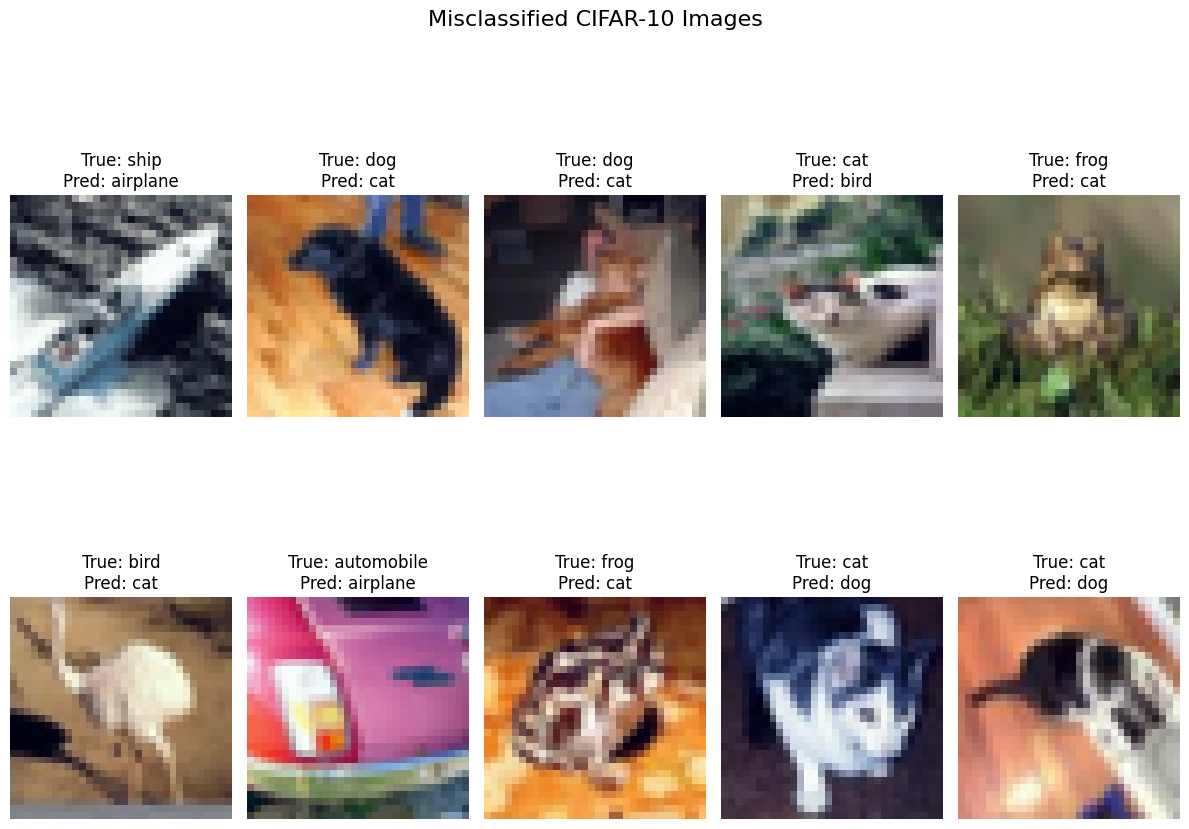

In [37]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
# Unnormalize for visualization
def unnormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1)
    return img * std + mean

# Plot 5×2 grid
fig, axes = plt.subplots(2, 5, figsize=(12, 10))
fig.suptitle("Misclassified CIFAR-10 Images", fontsize=16)

for idx, (img, true_label, pred_label) in enumerate(misclassified[:10]):
    ax = axes[idx % 2, idx // 2]
    rgb_img = img.permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())  # Normalize
    ax.imshow(rgb_img)
    ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [24]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=05051a8967cf4f5f6e62ffca3795f291a9191cb77353fb0731bd2f10095b3c82
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [29]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms

target_layer = model.layer4[-1]  # Last conv layer in ResNet18
cam = GradCAM(model=model, target_layers=[target_layer])

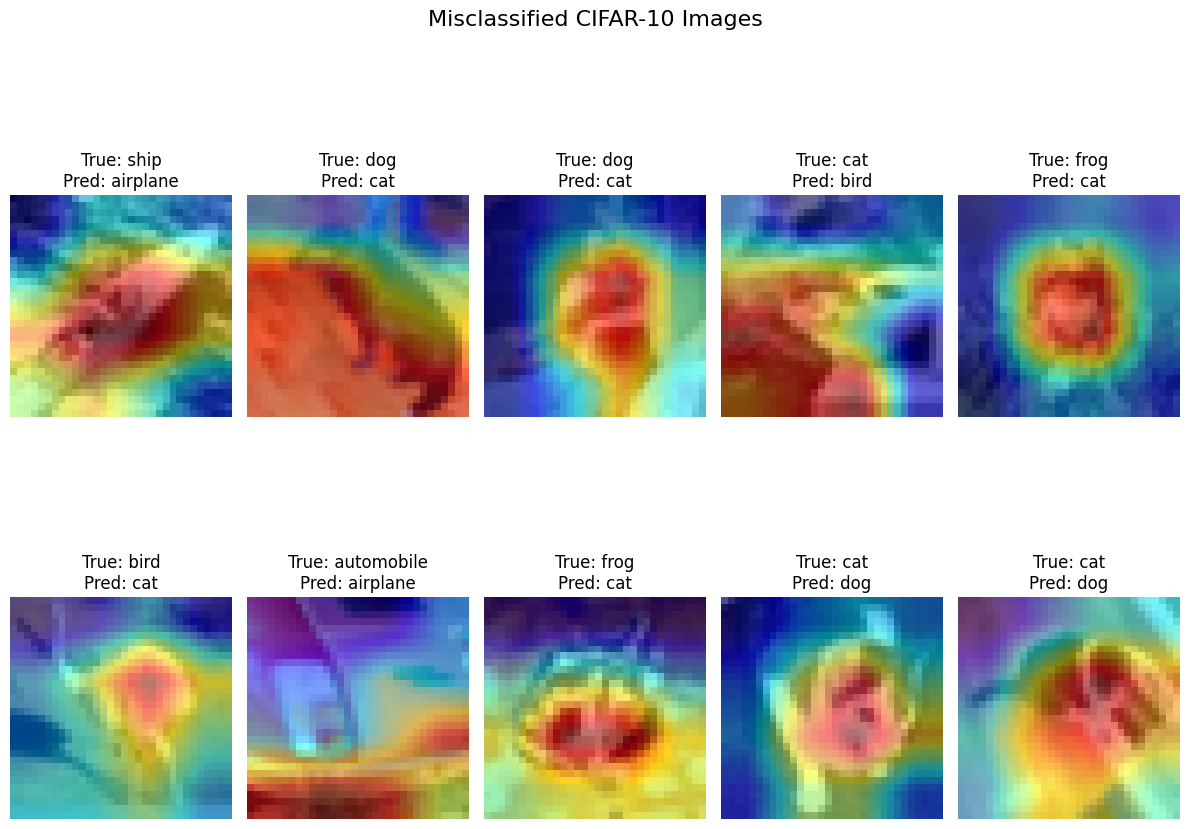

In [38]:
# Plot 5×2 grid
fig, axes = plt.subplots(2, 5, figsize=(12, 10))
fig.suptitle("Misclassified CIFAR-10 Images", fontsize=16)

for idx, (img, true_label, pred_label) in enumerate(misclassified[:10]):
    ax = axes[idx % 2, idx // 2]
    input_tensor = img.unsqueeze(0)
    targets = [ClassifierOutputTarget(pred_label.item())]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    rgb_img = img.permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())  # Normalize

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
    ax.imshow(cam_image)
    ax.axis('off')

plt.tight_layout()
plt.show()